## Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from selenium.webdriver.edge.options import Options
import time
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import json

## Definitions

In [2]:
def random_portfolio(symbols_list,data,n):
    sample = random.sample(symbols_list,n)
    return data[sample]

In [3]:
def portfolio_opti(portfolio):
    stocks = random.sample(symbols, 10)

    # Download daily price data for each of the stocks in the portfolio
    data = yf.download(stocks, start='2023-01-01')['Adj Close']
    data.sort_index(inplace=True)
    
    # Convert daily stock prices into daily returns
    returns = data.pct_change()
    
    # Calculate mean daily return and covariance of daily returns
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Set number of runs of random portfolio weights
    num_portfolios = 25000
    
    # Set up array to hold results
    # The number of rows is 3 (for 'ret', 'stdev', 'sharpe') plus the number of stocks
    num_stocks = len(stocks)
    results = np.zeros((3 + num_stocks, num_portfolios))
    
    for i in range(num_portfolios):
        # Select random weights for portfolio holdings
        weights = np.random.random(num_stocks)
        # Rebalance weights to sum to 1
        weights /= np.sum(weights)
        
        # Calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        
        # Store results in results array
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        # Store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results[2, i] = results[0, i] / results[1, i]
        # Iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results[j + 3, i] = weights[j]
    
    # Convert results array to Pandas DataFrame
    column_names = ['ret', 'stdev', 'sharpe'] + stocks
    results_frame = pd.DataFrame(results.T, columns=column_names)
    
    # Locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    
    # Locate position of portfolio with minimum standard deviation
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
    
    # Print the weights of the portfolio with the highest Sharpe ratio
    print("Portfolio with the highest Sharpe Ratio (Red Star):")
    for stock, weight in max_sharpe_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    print("\n")
    
    # Print the weights of the portfolio with the minimum variance
    print("Portfolio with the Minimum Variance (Green Star):")
    for stock, weight in min_vol_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    print("\n")
    
    # Create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()
    
    # Plot red star to highlight position of portfolio with highest Sharpe Ratio
    plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5, 1, 0), color='r', s=500)
    
    # Plot green star to highlight position of minimum variance portfolio
    plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5, 1, 0), color='g', s=500)
    
    plt.show()


In [4]:
def portfolio_corr_matrix(portfolio):
    correlation_matrix = portfolio.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(25, 25))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title('ETF Correlation Heatmap')

In [5]:
def portfolio_individual_plot(portfolio):
    symbols = list(portfolio.columns)
    plt.figure(figsize=(25, 15))
    for ticker in symbols:
        portfolio[f"{ticker}"].plot(label=ticker)

    plt.title("ETFs Time Series Comparison")
    plt.legend()

In [6]:
def portfolio_top_corr(portfolio,order = True):
    correlation_values = (portfolio.corr()).unstack()
    sorted_correlation_values = correlation_values[correlation_values != 1.0].sort_values(ascending=order)

    top_correlations = sorted_correlation_values.drop_duplicates()
    
    return top_correlations

In [7]:
def portfolio_performance(portfolio):
    returns = portfolio.pct_change()
    alphas = .05*np.ones(returns.shape[1])
    portfolio = np.random.dirichlet(alphas, size=1)
    
    plt.plot(returns.fillna(0).dot(portfolio.T).add(1).cumprod().sub(1), color='r')
    plt.title('Random Portfolio Performance')
    plt.xlabel('Time (days)')
    plt.ylabel('Return')

In [8]:
def get_quote(symbol):
    msft = yf.Ticker(symbol)
    try:
        hist = msft.history(period="2d")
    except json.decoder.JSONDecodeError:
        return None
    try:
        hist.reset_index(inplace=True)
        jsdata = json.loads(hist.to_json())
        return jsdata["Close"]["0"]
    except (ValueError, KeyError) as e:
       return None

In [9]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
import time
import urllib.parse as urlparse
from urllib.parse import parse_qs

def web_lookup(isin):
    # Specify the path to the Edge WebDriver executable
    msedgedriver_path = "C:\\Users\\Irish\\Downloads\\edgedriver_win32\\msedgedriver.exe"
    service = Service(msedgedriver_path)

    # Configure Edge options
    options = Options()
    options.add_argument("--incognito")
    options.add_argument("--disable-notifications")

    # Create an instance of the Edge browser with the specified options and service
    browser = webdriver.Edge(service=service, options=options)

    # Visit the Yahoo Finance lookup page
    browser.get("https://finance.yahoo.com/lookup")

    # Fill in the search input with the ISIN and submit the form
    search_input = browser.find_element_by_id("yfin-usr-qry")
    search_input.send_keys(isin)
    submit_button = browser.find_element_by_type("submit")
    submit_button.click()

    # Wait for the page to load
    time.sleep(5)

    # Parse the current URL of the browser
    parsed = urlparse.urlparse(browser.current_url)
    try:
        # Attempt to extract the ticker symbol from the query parameters
        ticker = parse_qs(parsed.query)['p'][0]
    except KeyError:
        # If the ticker is not found, default to "n/a"
        ticker = "n/a"

    # Close the browser
    browser.quit()

    return ticker


In [10]:
import requests


def get_symbol_for_isin(isin):
    url = 'https://query1.finance.yahoo.com/v1/finance/search'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.109 Safari/537.36',
    }
    params = dict(
        q=isin,
        quotesCount=1,
        newsCount=0,
        listsCount=0,
        quotesQueryId='tss_match_phrase_query'
    )
    resp = requests.get(url=url, headers=headers, params=params)
    data = resp.json()
    if 'quotes' in data and len(data['quotes']) > 0:
        return data['quotes'][0]['symbol']
    else:
        return None

In [28]:
print(get_symbol_for_isin("LU0616856935"))

FP7X.F


In [30]:
import nseinfopackage

In [32]:
nseinfopackage.getSymbol('INE009A01021')

AttributeError: module 'nseinfopackage' has no attribute 'getSymbol'

## Main

In [12]:
intraday_price = True
morningstar_performance = True
region = True
avg_vol_3mo = False
category = False
volume = False
price_end_day = False
volume_end_day = False
exchange = False
week_price_change = False
company = False
net_assets = False
initial_minimum_investment = False
price = False
intraday_price_change = False
long_market_cap_val = False
intraday_price_change_percentage = False
symbol = False

In [13]:
# Spécifiez le chemin vers msedgedriver
msedgedriver_path = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\msedgedriver.exe"
# ATTENTION A CE QUE LE CHEMIN SOIT LE BON !
service = Service(msedgedriver_path)

# Configurez les options de Edge
options = Options()
options.add_argument("--incognito")
options.add_argument("--disable-notifications")

# Créez une instance du navigateur Edge avec les options et le service spécifiés
browser = webdriver.Edge(service=service, options=options)

# URL de la page de connexion
path = "https://login.yahoo.com/config/login?.src=finance&.intl=us&.lang=en-US&.done=https%3A%2F%2Ffinance.yahoo.com%2Fquotes%2Flogin%2Fview%2Fv1%2F"
browser.get(path)

# Remplissez le formulaire de connexion
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "username"))).send_keys("irishrugbyman@gmail.com")
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "signin"))).click()
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "password"))).send_keys("F$Pi2YahooFinance20")
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.ID, "login-signin"))).click()

# Accédez à l'URL de la page du screener Yahoo Finance
url = "https://finance.yahoo.com/screener/1745ba28-6f7f-4504-a2db-9a98b89ff912?offset=0&count=100"
browser.get(url)

# Attendez que la page charge et que le tableau soit présent
time.sleep(5)
# Utilisez WebDriverWait et EC pour une approche plus robuste

# Récupérez le contenu HTML de la page
content = browser.page_source

# Utilisez pandas pour lire le tableau directement à partir du contenu HTML
dfs = pd.read_html(content)
df = dfs[0]

# Fermez le navigateur
browser.quit()

# Récupérez la liste des symboles
symbols = df["Symbol"].tolist()

# Utilisez yfinance pour télécharger les données des ETFs
etf_data = yf.download(symbols, start='2023-01-01')['Adj Close']
etf_data

[*********************100%%**********************]  100 of 100 completed


,AH50.DE,BNXG.DE,CNDX.AS,CNDX.L,CNX1.L,CNXT,CSNKY.MI,DBX5.DE,EL41.DE,EL4E.DE,...,XMTD.L,XMTW.L,XNKY.DE,XSTC.L,XUTC.DE,XUTC.L,XUTC.MI,XZMU.SW,ZPAL.SW,ZPDT.DE
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,25.889999,51.580002,592.599976,NaN,NaN,NaN,183.179993,40.320000,23.844999,30.564375,...,NaN,NaN,58.590000,NaN,52.090000,NaN,50.470001,NaN,NaN,61.810001
2023-01-03,26.215000,51.570000,581.599976,613.280029,51286.5,31.468000,183.350006,40.720001,23.530001,30.489876,...,42.865002,3576.5,58.680000,4492.50,50.939999,53.482086,51.020000,NaN,485.350006,60.490002
2023-01-04,26.570000,52.750000,583.700012,621.599976,51444.5,31.566999,181.240005,40.700001,23.825001,30.708406,...,43.369999,3603.0,57.980000,4497.50,51.279999,53.780148,51.040001,NaN,495.000000,60.919998
2023-01-05,27.280001,52.720001,580.799988,611.500000,51361.0,32.248001,179.440002,40.980000,23.680000,30.971634,...,43.119999,3622.0,57.470001,4482.75,50.709999,53.020092,50.660000,NaN,485.000000,60.349998
2023-01-06,27.510000,52.939999,583.900024,619.104980,51394.0,33.139999,181.830002,41.650002,23.785000,31.274595,...,44.115002,3662.0,58.169998,4471.00,50.830002,53.501957,50.779999,NaN,497.000000,60.540001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,20.385000,70.699997,874.500000,959.380005,75180.0,22.599001,223.089996,47.985001,25.170000,33.660000,...,52.669998,4123.5,71.610001,6622.50,77.000000,84.510002,77.029999,NaN,248.000000,91.239998
2024-01-15,20.260000,70.220001,875.799988,958.789978,75356.0,NaN,225.320007,47.715000,25.135000,33.570000,...,52.264999,4103.0,72.320000,6641.00,77.250000,84.559998,77.220001,NaN,243.399994,91.500000
2024-01-16,20.320000,70.290001,882.200012,961.500000,75842.0,22.330000,223.869995,47.195000,24.770000,33.165001,...,51.375000,4055.0,71.839996,6711.50,78.110001,85.070000,78.089996,NaN,237.750000,92.510002


In [26]:
test_port = yf.download(symbols, start='2023-01-01')

[*********************100%%**********************]  100 of 100 completed


In [27]:
test_port

Adj Close                                                          
              AH50.DE    BNXG.DE     CNDX.AS      CNDX.L   CNX1.L       CNXT   
Date                                                                           
2023-01-02  25.889999  51.580002  592.599976         NaN      NaN        NaN  \
2023-01-03  26.215000  51.570000  581.599976  613.280029  51286.5  31.468000   
2023-01-04  26.570000  52.750000  583.700012  621.599976  51444.5  31.566999   
2023-01-05  27.280001  52.720001  580.799988  611.500000  51361.0  32.248001   
2023-01-06  27.510000  52.939999  583.900024  619.104980  51394.0  33.139999   
...               ...        ...         ...         ...      ...        ...   
2024-01-12  20.385000  70.699997  874.500000  959.380005  75180.0  22.599001   
2024-01-15  20.260000  70.220001  875.799988  958.789978  75356.0        NaN   
2024-01-16  20.320000  70.290001  882.200012  961.500000  75842.0  22.330000   
2024-01-17  19.704000  67.760002  876.400024  951.630005  75060.5  21.693001   
2024-01-18  20.025000  68.809998  889.400024  967.020020  76222.0  22.070000   

                                                         ...  Volume           
              CSNKY.MI    DBX5.DE    EL41.DE    EL4E.DE  ...  XMTD.L  XMTW.L   
Date                                                     ...                   
2023-01-02  183.179993  40.320000  23.844999  30.564375  ...     NaN     NaN  \
2023-01-03  183.350006  40.720001  23.530001  30.489874  ...     0.0     0.0   
2023-01-04  181.240005  40.700001  23.825001  30.708406  ...  2796.0  2513.0   
2023-01-05  179.440002  40.980000  23.680000  30.971634  ...  2482.0  3789.0   
2023-01-06  181.830002  41.650002  23.785000  31.274595  ...     0.0     0.0   
...                ...        ...        ...        ...  ...     ...     ...   
2024-01-12  223.089996  47.985001  25.170000  33.660000  ...  1050.0     0.0   
2024-01-15  225.320007  47.715000  25.135000  33.570000  ...     0.0    96.0   
2024-01-16  223.869995  47.195000  24.770000  33.165001  ...     0.0  1090.0   
2024-01-17  218.470001  46.509998  24.650000  32.505001  ...   238.0     0.0   
2024-01-18  221.910004  47.730000  25.065001  33.384998  ...  1141.0  9940.0   

                                                                          
            XNKY.DE   XSTC.L  XUTC.DE   XUTC.L XUTC.MI  XZMU.SW ZPAL.SW   
Date                                                                      
2023-01-02      0.0      NaN   3784.0      NaN     0.0      NaN     NaN  \
2023-01-03    736.0   1758.0   7164.0   6218.0   320.0      NaN   411.0   
2023-01-04   8528.0    214.0   5413.0    160.0   334.0      NaN   237.0   
2023-01-05   3977.0     30.0   4657.0      0.0    83.0      NaN  2271.0   
2023-01-06    975.0    320.0   3822.0    515.0    20.0      NaN   116.0   
...             ...      ...      ...      ...     ...      ...     ...   
2024-01-12   1403.0    201.0   3624.0  21264.0  1100.0      NaN   337.0   
2024-01-15   2245.0    268.0   6587.0  12325.0  2088.0      NaN  1142.0   
2024-01-16   4981.0   4578.0  17673.0  20606.0  9290.0      NaN  1312.0   
2024-01-17   1089.0    114.0   4913.0  16193.0   760.0      NaN   531.0   
2024-01-18  12625.0  12052.0   9088.0  41439.0  3328.0  62700.0  1045.0   

                     
            ZPDT.DE  
Date                 
2023-01-02    831.0  
2023-01-03   6417.0  
2023-01-04   4371.0  
2023-01-05    783.0  
2023-01-06   2766.0  
...             ...  
2024-01-12  15802.0  
2024-01-15   6923.0  
2024-01-16  11409.0  
2024-01-17   4090.0  
2024-01-18  25536.0  

[271 rows x 600 columns]

In [14]:
test = ["FR0010149302","LU0616856935"]
test_data = yf.download(test, start='2023-01-01')['Adj Close']
test_data

[*********************100%%**********************]  2 of 2 completed


,FR0010149302,LU0616856935
Date,,
2024-01-18,1093.68396,165.238998


In [15]:
ran_port = (random_portfolio(symbols,etf_data,10))

ran_port = ran_port.bfill()
ran_port

,VGT.MX,TNOW.PA,TNOW.L,GWT.PA,EXXT.DE,WTAI.MI,XMTW.L,ZPAL.SW,XZMU.SW,SMH
Date,,,,,,,,,,
2023-01-02,6154.970215,431.890015,447.052795,147.979996,101.879997,38.514999,3576.5,485.350006,46.794998,100.086716
2023-01-03,6144.330078,422.500000,447.052795,150.199997,99.870003,38.264999,3576.5,485.350006,46.794998,100.086716
2023-01-04,6184.310059,424.980011,449.011108,153.000000,100.720001,38.974998,3603.0,495.000000,46.794998,102.631378
2023-01-05,6052.000000,421.149994,440.435303,153.279999,99.870003,38.599998,3622.0,485.000000,46.794998,100.792465
2023-01-06,6137.000000,423.079987,453.089691,155.399994,100.320000,39.110001,3662.0,497.000000,46.794998,105.200890
...,...,...,...,...,...,...,...,...,...,...
2024-01-12,8108.000000,629.469971,690.937195,169.899994,149.179993,54.369999,4123.5,248.000000,44.770000,172.949997
2024-01-15,8108.000000,631.280029,690.815125,169.419998,149.639999,54.450001,4103.0,243.399994,44.770000,175.699997
2024-01-16,8248.169922,637.909973,692.230591,168.860001,150.899994,54.720001,4055.0,237.750000,44.770000,175.699997


[*********************100%%**********************]  10 of 10 completed
Portfolio with the highest Sharpe Ratio (Red Star):
XLKS.L: 3.48%
IUIT.L: 0.87%
TNOW.MI: 13.92%
EWT: 0.62%
GLUX.DE: 15.69%
ESREUA.SW: 6.59%
TECW.L: 18.10%
XUTC.MI: 3.65%
WTAI.MI: 18.17%
ELFA.DE: 18.90%


Portfolio with the Minimum Variance (Green Star):
XLKS.L: 27.54%
IUIT.L: 2.47%
TNOW.MI: 27.09%
EWT: 3.30%
GLUX.DE: 1.46%
ESREUA.SW: 7.39%
TECW.L: 13.00%
XUTC.MI: 2.25%
WTAI.MI: 1.93%
ELFA.DE: 13.56%


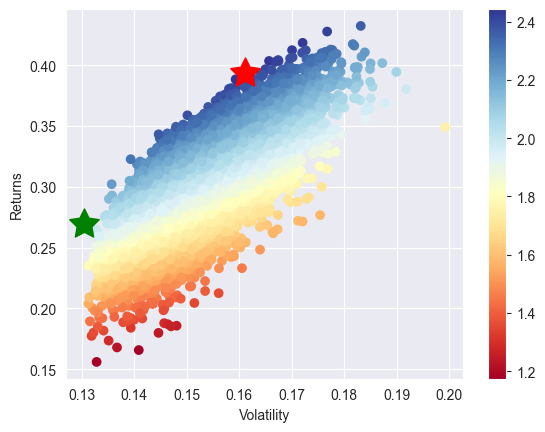

In [16]:
portfolio_opti(ran_port)

In [17]:
covariance = np.cov(ran_port.fillna(0).T)

In [18]:
portfolio_volatility = np.sqrt(np.dot(np.dot(ran_port, covariance), ran_port.T))

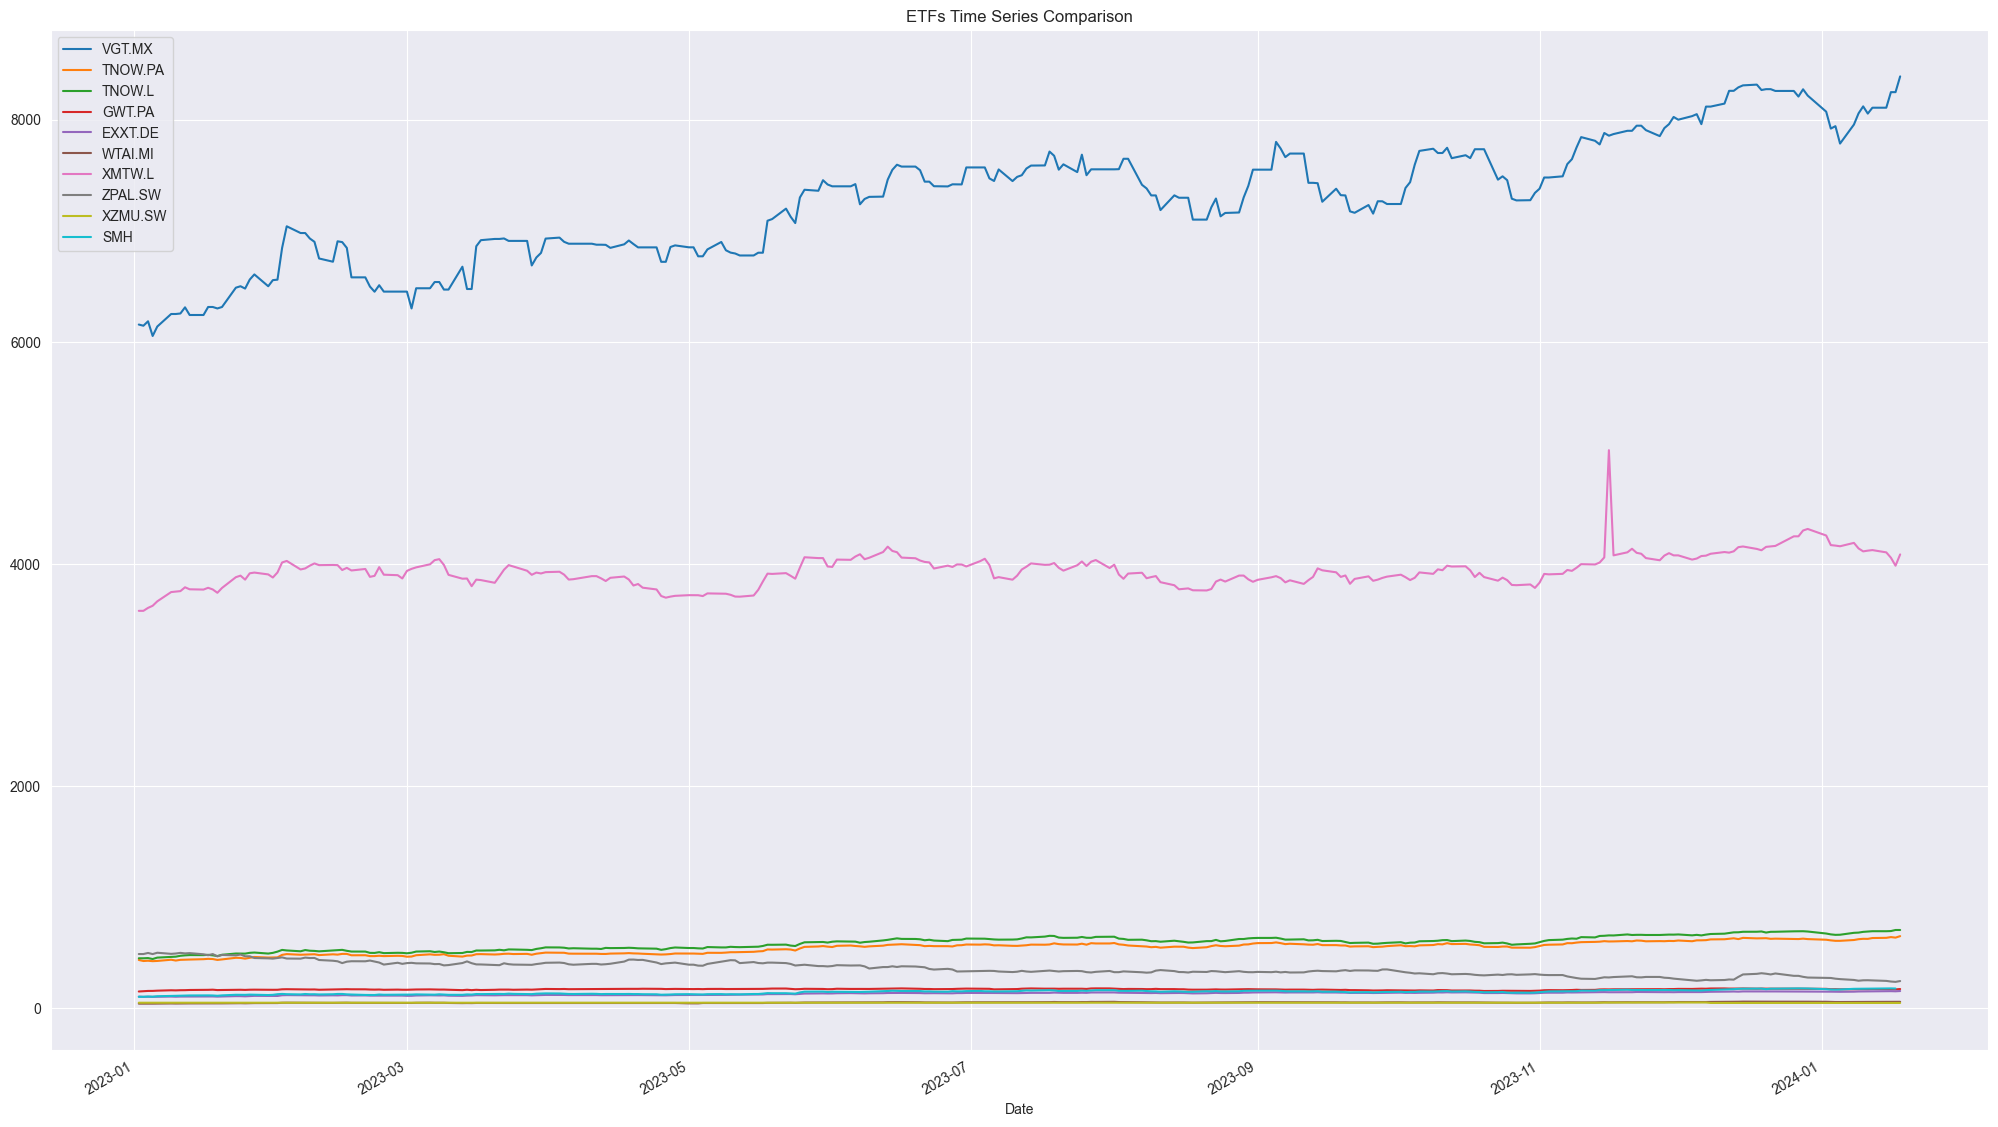

In [19]:
portfolio_individual_plot(ran_port)

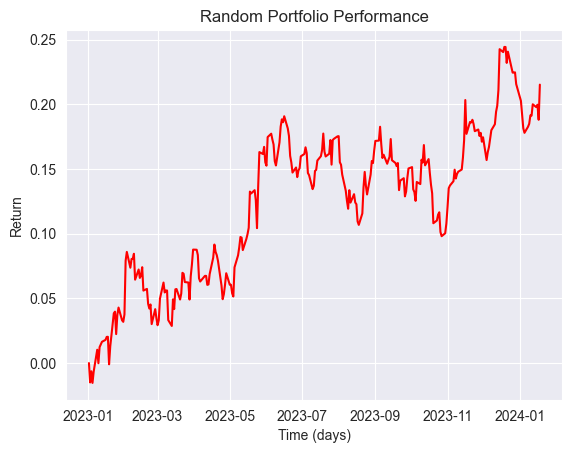

In [20]:
portfolio_performance(ran_port)

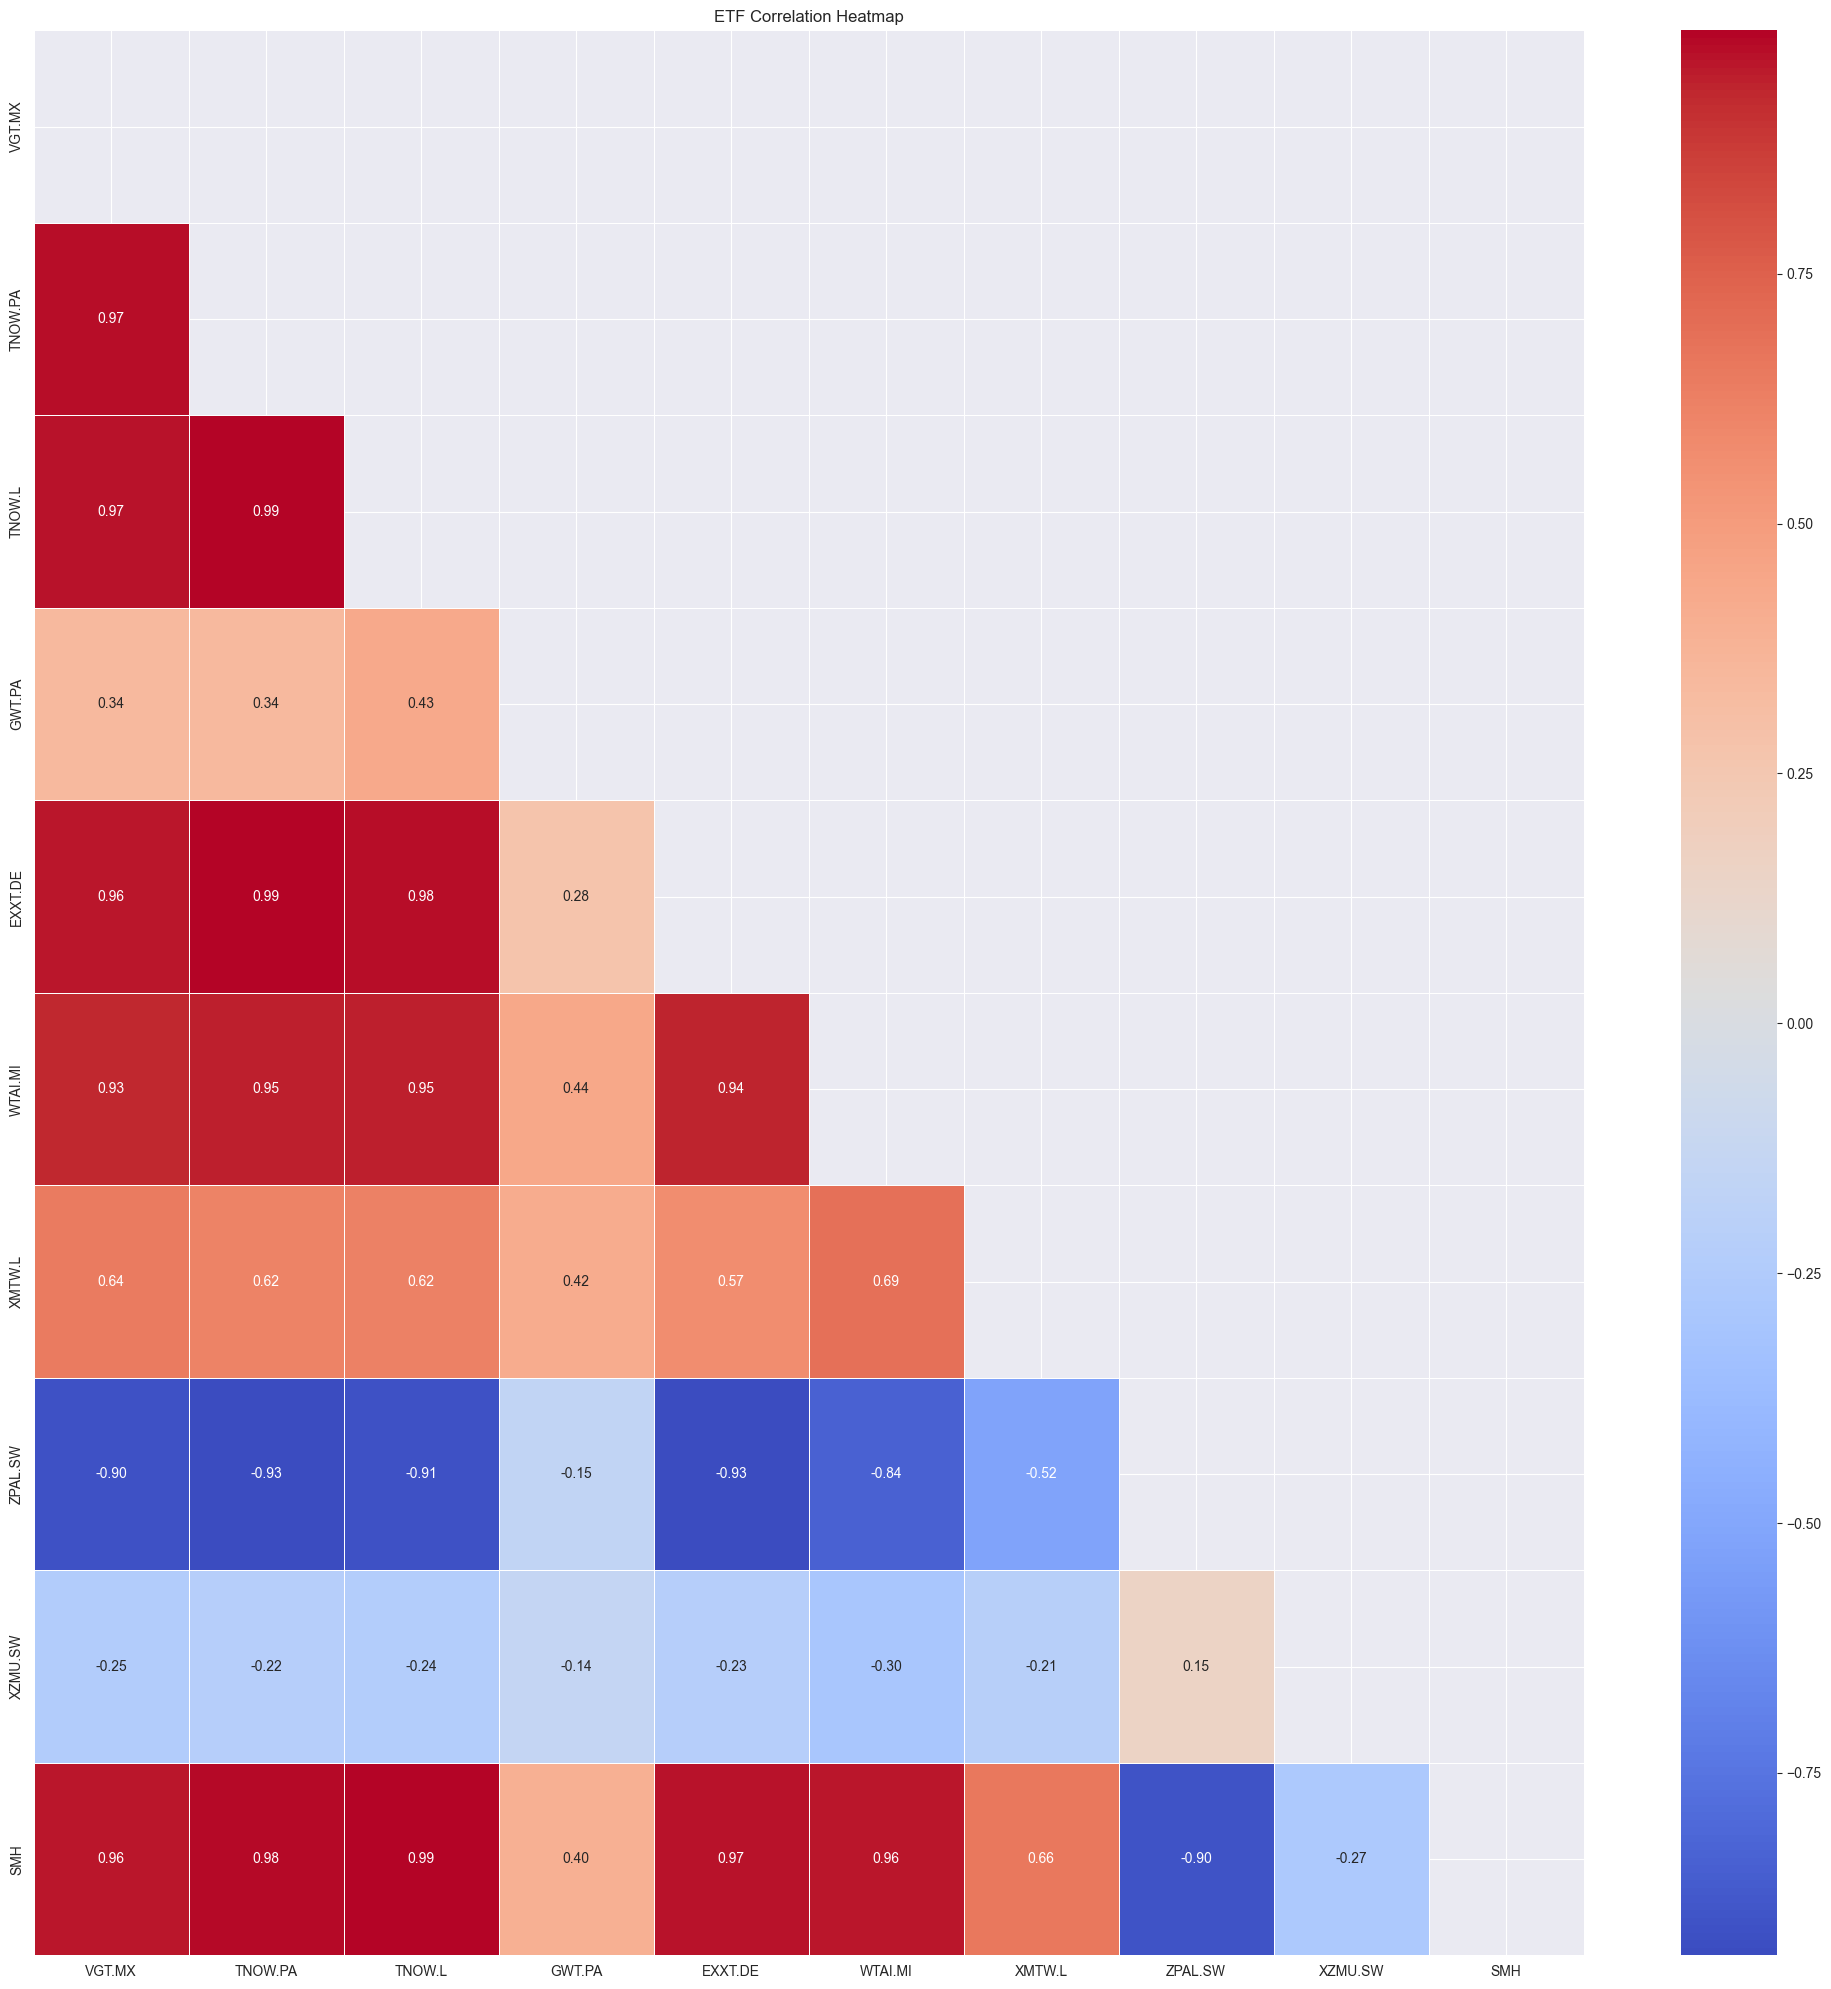

In [21]:
portfolio_corr_matrix(ran_port)

In [23]:
import pypfopt

# Read in price data
df = ran_port

# Calculate expected returns and sample covariance
mu = pypfopt.expected_returns.mean_historical_return(df)
S = pypfopt.risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = pypfopt.EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('VGT.MX', 0.0), ('TNOW.PA', 0.0), ('TNOW.L', 0.47503), ('GWT.PA', 0.0), ('EXXT.DE', 0.46254), ('WTAI.MI', 0.0), ('XMTW.L', 0.0), ('ZPAL.SW', 0.0), ('XZMU.SW', 0.0), ('SMH', 0.06242)])
Expected annual return: 50.1%
Annual volatility: 15.9%
Sharpe Ratio: 3.02


(0.5008600265928818, 0.15920075529193448, 3.0204632240035822)

AttributeError: module 'pypfopt' has no attribute 'plotting'

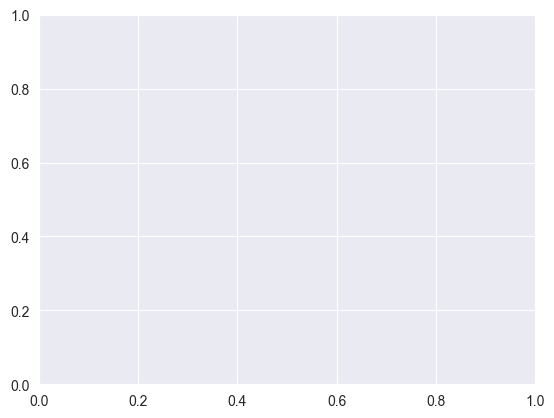

In [24]:
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
pypfopt.plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()